# Readability Assessment through Learning Techniques

* Readability assessment is a well known problem in natural language processing field. 
* Giving someone the suitable text for his level of comprehension (not so easy and not so hard) could maximize his understanding and enjoyment. 

In this notebook we are trying to assess the readability of a given text regardless of the text topic.

## Corpus
> OneStopEnglish corpus: A new corpus for automatic readability assessment and text simplification  
> Sowmya Vajjala and Ivana Lučić  
> 2018  
> Proceedings of the Thirteenth Workshop on Innovative Use of NLP for Building Educational Applications, pages 297–304. Association for Computational Linguistics.  
> [url](http://aclweb.org/anthology/W18-0535). [bib file](https://aclanthology.coli.uni-saarland.de/papers/W18-0535/w18-0535.bib)

Please cite the above paper if you use this corpus in your research.

[![DOI](https://zenodo.org/badge/128919409.svg)](https://zenodo.org/badge/latestdoi/128919409)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Now let's dive into our corpus.

In [2]:
import sys
sys.path.append("/home/ms10596/PycharmProjects/match")
from ipywidgets import interact
from tabulate import tabulate
from IPython.display import display, HTML

from utils.loading import load_glove_embeddings, load_old_corpus
from utils.one_stop_english import load_corpus, corpus_to_words, corpus_to_pos, detokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional,Conv1D,MaxPooling1D,GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np

corpus = load_corpus()
articles_words, tags = corpus_to_words(corpus)
articles_pos, tags = corpus_to_pos(corpus)
old_articles_pos, old_articles_tags = load_old_corpus()

Reading level|Avg. Num. Words|Std. Dev|Number of Articles
---|---|---|---
Elementary|533.17|103.79|189
Intermediate|676.59|117.15|189
Advanced|820.49|162.52|189



In [3]:
@interact
def show_articles(i=(0,188,1), words=(0,1000,1)):
    data = [
        ["Advanced",detokenize(articles_words[i][:words])], 
        ["Intermediate",detokenize(articles_words[i+2][:words])], 
        ["Elementary",detokenize(articles_words[i+1][:words])]
    ]
    headers = ['Reading Level', 'Example']
    display(HTML(tabulate(data,tablefmt='html', headers=headers)+"<style>th,td {font-size: 20px}</style>"))

interactive(children=(IntSlider(value=94, description='i', max=188), IntSlider(value=500, description='words',…

In [4]:
print(articles_words[0][:10])
print(articles_pos[0][:10])

['When', 'you', 'see', 'the', 'word', 'Amazon', ',', 'whats', 'the', 'first']
['WRB', 'PRP', 'VB', 'DT', 'NN', 'NN', ',', 'VBZ', 'DT', 'JJ']


In [5]:
import json
maxlen = 1000 # Cuts off reviews after 1000 words
max_words = 45
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(articles_pos)

with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))
print(tokenizer.word_index)

{'nn': 1, 'in': 2, 'dt': 3, 'jj': 4, 'nns': 5, 'nnp': 6, ',': 7, '.': 8, 'rb': 9, 'prp': 10, 'vb': 11, 'vbd': 12, 'cc': 13, 'vbz': 14, 'to': 15, 'vbp': 16, 'cd': 17, 'vbn': 18, 'vbg': 19, 'prp$': 20, 'md': 21, 'wdt': 22, 'wrb': 23, 'wp': 24, 'jjr': 25, 'rp': 26, ':': 27, 'jjs': 28, 'ex': 29, 'rbr': 30, 'nnps': 31, '-rrb-': 32, '-lrb-': 33, 'rbs': 34, 'pdt': 35, '$': 36, 'fw': 37, 'uh': 38, 'wp$': 39, 'sym': 40, "''": 41, 'ls': 42, 'pos': 43, '``': 44}


In [7]:
sequences = tokenizer.texts_to_sequences(articles_pos)
old_sequences = tokenizer.texts_to_sequences(old_articles_pos)
print(np.shape(sequences))
print(np.shape(old_sequences))
# print(sequences[0])

(567,)
(183,)


In [8]:
data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
old_data = pad_sequences(old_sequences, maxlen=maxlen, padding='post', truncating='post')
# print(data[0])
print(np.shape(data))
print(np.shape(old_data))

(567, 1000)
(183, 1000)


In [11]:
print(tags[0])
print(old_articles_tags[0])
tags = np.array(tags)
old_tags = np.array(old_articles_tags)
print(tags.shape)
print(old_tags.shape)

2
0
(567,)
(183,)


In [12]:
data = to_categorical(data)
old_data = to_categorical(old_data)
print(data.shape)
print(old_data.shape)

(567, 1000, 45)
(183, 1000, 45)


In [16]:
np.random.seed(0)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
tags = tags[indices]

old_indices = np.arange(old_data.shape[0])
np.random.shuffle(indices)

old_data = old_data[old_indices]
old_tags = old_tags[old_indices]
print(data.shape)
print(tags.shape)

print(old_data.shape)
print(old_tags.shape)

(567, 1000, 45)
(567,)
(183, 1000, 45)
(183,)


In [23]:
model = Sequential()
model.add(Conv1D(128, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(1000,45)))
# model.add(MaxPooling1D(5))
# model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
# model.add(MaxPooling1D(5))
# model.add(Conv1D(32, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.0003, l2=0.0003)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
# model.summary()
def soft_acc(y_true, y_pred):
    from tensorflow.python.keras import backend as K
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [29]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvs_scores = []
for train, test in kfold.split(data, tags):
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(1000,45)))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(32, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.0003, l2=0.0003)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1))
    # model.summary()
    def soft_acc(y_true, y_pred):
        from tensorflow.python.keras import backend as K
        return K.mean(K.equal(K.round(y_true), K.round(y_pred)))
    model.compile(optimizer=RMSprop(),loss='mse',metrics=[soft_acc])
    model.fit(data[train], tags[train], epochs=2000, verbose=0)
    scores = model.evaluate(data[test], tags[test], verbose=0)
    print(scores[1]*100)
    cvs_scores.append(scores[1]*100)
print("Accuracy:", np.mean(cvs_scores),"std:", np.std(cvs_scores))

61.40350887649938
66.66666792150129
49.122808272378485
45.614034617156314
64.91228080632393
54.385964807711154
57.89473715581393
73.68421178115042
64.91228101546305
55.555556217829384
Accuracy: 59.415205147182725 std: 8.120868247309904


In [24]:
es = EarlyStopping(monitor='val_soft_acc',patience=100, mode='max')
cp = ModelCheckpoint('model-{epoch:03d}-{soft_acc:03f}-{val_soft_acc:03f}.h5', verbose=1, monitor='val_soft_acc',save_best_only=True, mode='max')  
model.compile(optimizer=RMSprop(),loss='mse',metrics=[soft_acc])
history = model.fit(data, tags,epochs=1000,  batch_size=50,validation_data=(old_data, old_tags),callbacks=[])
# model.save_weights('pre_trained_glove_model.h5')
model.summary()

Train on 567 samples, validate on 183 samples
Epoch 1/1000
567/567 [==============================] - 1s 1ms/step - loss: 10.5895 - soft_acc: 0.3422 - val_loss: 8.1185 - val_soft_acc: 0.3880
Epoch 2/1000
567/567 [==============================] - 0s 601us/step - loss: 7.0422 - soft_acc: 0.3333 - val_loss: 5.5487 - val_soft_acc: 0.3880
Epoch 3/1000
567/567 [==============================] - 0s 607us/step - loss: 4.8023 - soft_acc: 0.3333 - val_loss: 3.6700 - val_soft_acc: 0.3880
Epoch 4/1000
567/567 [==============================] - 0s 599us/step - loss: 3.1619 - soft_acc: 0.3333 - val_loss: 2.3152 - val_soft_acc: 0.3880
Epoch 5/1000
567/567 [==============================] - 0s 592us/step - loss: 2.0247 - soft_acc: 0.3333 - val_loss: 1.4409 - val_soft_acc: 0.3880
Epoch 6/1000
567/567 [==============================] - 0s 593us/step - loss: 1.3426 - soft_acc: 0.3333 - val_loss: 1.0048 - val_soft_acc: 0.4044
Epoch 7/1000
567/567 [==============================] - 0s 589us/step - loss: 1

567/567 [==============================] - 0s 595us/step - loss: 0.5982 - soft_acc: 0.5132 - val_loss: 0.6212 - val_soft_acc: 0.6448
Epoch 57/1000
567/567 [==============================] - 0s 596us/step - loss: 0.5916 - soft_acc: 0.5097 - val_loss: 0.6195 - val_soft_acc: 0.6448
Epoch 58/1000
567/567 [==============================] - 0s 591us/step - loss: 0.5930 - soft_acc: 0.5168 - val_loss: 0.6674 - val_soft_acc: 0.6776
Epoch 59/1000
567/567 [==============================] - 0s 597us/step - loss: 0.5897 - soft_acc: 0.5344 - val_loss: 0.6142 - val_soft_acc: 0.6175
Epoch 60/1000
567/567 [==============================] - 0s 595us/step - loss: 0.5917 - soft_acc: 0.5097 - val_loss: 0.6331 - val_soft_acc: 0.6557
Epoch 61/1000
567/567 [==============================] - 0s 591us/step - loss: 0.5856 - soft_acc: 0.5273 - val_loss: 0.6261 - val_soft_acc: 0.6503
Epoch 62/1000
567/567 [==============================] - 0s 597us/step - loss: 0.5811 - soft_acc: 0.5326 - val_loss: 0.6181 - val_so

Epoch 112/1000
567/567 [==============================] - 0s 561us/step - loss: 0.5097 - soft_acc: 0.6578 - val_loss: 0.6748 - val_soft_acc: 0.6339
Epoch 113/1000
567/567 [==============================] - 0s 562us/step - loss: 0.5056 - soft_acc: 0.6508 - val_loss: 0.7297 - val_soft_acc: 0.5956
Epoch 114/1000
567/567 [==============================] - 0s 560us/step - loss: 0.5065 - soft_acc: 0.6614 - val_loss: 0.7744 - val_soft_acc: 0.5574
Epoch 115/1000
567/567 [==============================] - 0s 561us/step - loss: 0.5095 - soft_acc: 0.6649 - val_loss: 0.7013 - val_soft_acc: 0.6066
Epoch 116/1000
567/567 [==============================] - 0s 562us/step - loss: 0.5067 - soft_acc: 0.6526 - val_loss: 0.7033 - val_soft_acc: 0.6066
Epoch 117/1000
567/567 [==============================] - 0s 566us/step - loss: 0.4979 - soft_acc: 0.6861 - val_loss: 0.6567 - val_soft_acc: 0.6393
Epoch 118/1000
567/567 [==============================] - 0s 562us/step - loss: 0.4991 - soft_acc: 0.6684 - val_

567/567 [==============================] - 0s 638us/step - loss: 0.4623 - soft_acc: 0.7249 - val_loss: 0.7699 - val_soft_acc: 0.4863
Epoch 168/1000
567/567 [==============================] - 0s 599us/step - loss: 0.4607 - soft_acc: 0.7284 - val_loss: 0.9029 - val_soft_acc: 0.3825
Epoch 169/1000
567/567 [==============================] - 0s 607us/step - loss: 0.4656 - soft_acc: 0.7196 - val_loss: 0.7556 - val_soft_acc: 0.4973
Epoch 170/1000
567/567 [==============================] - 0s 602us/step - loss: 0.4585 - soft_acc: 0.7302 - val_loss: 0.7373 - val_soft_acc: 0.5137
Epoch 171/1000
567/567 [==============================] - 0s 616us/step - loss: 0.4586 - soft_acc: 0.7443 - val_loss: 0.7857 - val_soft_acc: 0.4809
Epoch 172/1000
567/567 [==============================] - 0s 601us/step - loss: 0.4595 - soft_acc: 0.7460 - val_loss: 0.8687 - val_soft_acc: 0.4098
Epoch 173/1000
567/567 [==============================] - 0s 604us/step - loss: 0.4552 - soft_acc: 0.7460 - val_loss: 0.8404 - 

567/567 [==============================] - 0s 592us/step - loss: 0.4346 - soft_acc: 0.7654 - val_loss: 0.8180 - val_soft_acc: 0.4262
Epoch 223/1000
567/567 [==============================] - 0s 601us/step - loss: 0.4285 - soft_acc: 0.7637 - val_loss: 0.7089 - val_soft_acc: 0.4973
Epoch 224/1000
567/567 [==============================] - 0s 603us/step - loss: 0.4339 - soft_acc: 0.7496 - val_loss: 0.7470 - val_soft_acc: 0.4754
Epoch 225/1000
567/567 [==============================] - 0s 596us/step - loss: 0.4281 - soft_acc: 0.7743 - val_loss: 0.7767 - val_soft_acc: 0.4645
Epoch 226/1000
567/567 [==============================] - 0s 605us/step - loss: 0.4319 - soft_acc: 0.7513 - val_loss: 0.8472 - val_soft_acc: 0.4262
Epoch 227/1000
567/567 [==============================] - 0s 609us/step - loss: 0.4293 - soft_acc: 0.7637 - val_loss: 0.7387 - val_soft_acc: 0.4863
Epoch 228/1000
567/567 [==============================] - 0s 604us/step - loss: 0.4237 - soft_acc: 0.7778 - val_loss: 0.7498 - 

567/567 [==============================] - 0s 601us/step - loss: 0.4102 - soft_acc: 0.7989 - val_loss: 0.9733 - val_soft_acc: 0.3333
Epoch 278/1000
567/567 [==============================] - 0s 599us/step - loss: 0.4158 - soft_acc: 0.7831 - val_loss: 0.8984 - val_soft_acc: 0.3880
Epoch 279/1000
567/567 [==============================] - 0s 609us/step - loss: 0.4108 - soft_acc: 0.7831 - val_loss: 0.7595 - val_soft_acc: 0.4809
Epoch 280/1000
567/567 [==============================] - 0s 606us/step - loss: 0.4124 - soft_acc: 0.7972 - val_loss: 0.7973 - val_soft_acc: 0.4481
Epoch 281/1000
567/567 [==============================] - 0s 601us/step - loss: 0.4119 - soft_acc: 0.7884 - val_loss: 0.9714 - val_soft_acc: 0.3333
Epoch 282/1000
567/567 [==============================] - 0s 607us/step - loss: 0.4158 - soft_acc: 0.7919 - val_loss: 0.8608 - val_soft_acc: 0.4372
Epoch 283/1000
567/567 [==============================] - 0s 610us/step - loss: 0.4073 - soft_acc: 0.7972 - val_loss: 0.9246 - 

567/567 [==============================] - 0s 603us/step - loss: 0.3950 - soft_acc: 0.8060 - val_loss: 0.8426 - val_soft_acc: 0.4372
Epoch 333/1000
567/567 [==============================] - 0s 599us/step - loss: 0.4002 - soft_acc: 0.8131 - val_loss: 0.9824 - val_soft_acc: 0.3279
Epoch 334/1000
567/567 [==============================] - 0s 603us/step - loss: 0.3955 - soft_acc: 0.8236 - val_loss: 1.0362 - val_soft_acc: 0.3279
Epoch 335/1000
567/567 [==============================] - 0s 596us/step - loss: 0.4041 - soft_acc: 0.8113 - val_loss: 1.0381 - val_soft_acc: 0.3333
Epoch 336/1000
567/567 [==============================] - 0s 602us/step - loss: 0.3997 - soft_acc: 0.8095 - val_loss: 0.7684 - val_soft_acc: 0.4754
Epoch 337/1000
567/567 [==============================] - 0s 600us/step - loss: 0.3953 - soft_acc: 0.8113 - val_loss: 0.8630 - val_soft_acc: 0.4098
Epoch 338/1000
567/567 [==============================] - 0s 604us/step - loss: 0.3951 - soft_acc: 0.8325 - val_loss: 0.9284 - 

567/567 [==============================] - 0s 593us/step - loss: 0.3887 - soft_acc: 0.8289 - val_loss: 0.9430 - val_soft_acc: 0.3497
Epoch 388/1000
567/567 [==============================] - 0s 592us/step - loss: 0.3888 - soft_acc: 0.8307 - val_loss: 1.0447 - val_soft_acc: 0.3224
Epoch 389/1000
567/567 [==============================] - 0s 588us/step - loss: 0.3865 - soft_acc: 0.8289 - val_loss: 1.0048 - val_soft_acc: 0.3279
Epoch 390/1000
567/567 [==============================] - 0s 592us/step - loss: 0.3846 - soft_acc: 0.8448 - val_loss: 0.9572 - val_soft_acc: 0.3607
Epoch 391/1000
567/567 [==============================] - 0s 595us/step - loss: 0.3848 - soft_acc: 0.8448 - val_loss: 1.0209 - val_soft_acc: 0.3279
Epoch 392/1000
567/567 [==============================] - 0s 595us/step - loss: 0.3935 - soft_acc: 0.8166 - val_loss: 0.8928 - val_soft_acc: 0.3934
Epoch 393/1000
567/567 [==============================] - 0s 590us/step - loss: 0.3838 - soft_acc: 0.8413 - val_loss: 0.8291 - 

567/567 [==============================] - 0s 591us/step - loss: 0.3757 - soft_acc: 0.8466 - val_loss: 0.8023 - val_soft_acc: 0.4536
Epoch 443/1000
567/567 [==============================] - 0s 595us/step - loss: 0.3796 - soft_acc: 0.8519 - val_loss: 0.8296 - val_soft_acc: 0.4317
Epoch 444/1000
567/567 [==============================] - 0s 595us/step - loss: 0.3779 - soft_acc: 0.8466 - val_loss: 0.9098 - val_soft_acc: 0.4044
Epoch 445/1000
567/567 [==============================] - 0s 593us/step - loss: 0.3776 - soft_acc: 0.8430 - val_loss: 0.9955 - val_soft_acc: 0.3115
Epoch 446/1000
567/567 [==============================] - 0s 637us/step - loss: 0.3749 - soft_acc: 0.8624 - val_loss: 0.8815 - val_soft_acc: 0.4208
Epoch 447/1000
567/567 [==============================] - 0s 624us/step - loss: 0.3768 - soft_acc: 0.8430 - val_loss: 0.8803 - val_soft_acc: 0.4208
Epoch 448/1000
567/567 [==============================] - 0s 608us/step - loss: 0.3777 - soft_acc: 0.8395 - val_loss: 0.8461 - 

567/567 [==============================] - 0s 591us/step - loss: 0.3716 - soft_acc: 0.8660 - val_loss: 0.8917 - val_soft_acc: 0.4208
Epoch 498/1000
567/567 [==============================] - 0s 591us/step - loss: 0.3722 - soft_acc: 0.8624 - val_loss: 0.9656 - val_soft_acc: 0.3552
Epoch 499/1000
567/567 [==============================] - 0s 593us/step - loss: 0.3679 - soft_acc: 0.8730 - val_loss: 1.1398 - val_soft_acc: 0.2842
Epoch 500/1000
567/567 [==============================] - 0s 584us/step - loss: 0.3671 - soft_acc: 0.8519 - val_loss: 0.9528 - val_soft_acc: 0.3880
Epoch 501/1000
567/567 [==============================] - 0s 596us/step - loss: 0.3698 - soft_acc: 0.8536 - val_loss: 1.1051 - val_soft_acc: 0.3005
Epoch 502/1000
567/567 [==============================] - 0s 596us/step - loss: 0.3677 - soft_acc: 0.8571 - val_loss: 0.8915 - val_soft_acc: 0.4208
Epoch 503/1000
567/567 [==============================] - 0s 591us/step - loss: 0.3710 - soft_acc: 0.8677 - val_loss: 0.8296 - 

567/567 [==============================] - 0s 587us/step - loss: 0.3766 - soft_acc: 0.8466 - val_loss: 0.9529 - val_soft_acc: 0.3607
Epoch 553/1000
567/567 [==============================] - 0s 599us/step - loss: 0.3582 - soft_acc: 0.8801 - val_loss: 0.8198 - val_soft_acc: 0.4536
Epoch 554/1000
567/567 [==============================] - 0s 588us/step - loss: 0.3657 - soft_acc: 0.8554 - val_loss: 1.0128 - val_soft_acc: 0.3443
Epoch 555/1000
567/567 [==============================] - 0s 589us/step - loss: 0.3530 - soft_acc: 0.8942 - val_loss: 0.8342 - val_soft_acc: 0.4372
Epoch 556/1000
567/567 [==============================] - 0s 588us/step - loss: 0.3703 - soft_acc: 0.8448 - val_loss: 1.1069 - val_soft_acc: 0.3005
Epoch 557/1000
567/567 [==============================] - 0s 625us/step - loss: 0.3541 - soft_acc: 0.8871 - val_loss: 0.8692 - val_soft_acc: 0.4262
Epoch 558/1000
567/567 [==============================] - 0s 638us/step - loss: 0.3636 - soft_acc: 0.8695 - val_loss: 0.8818 - 

567/567 [==============================] - 0s 648us/step - loss: 0.3584 - soft_acc: 0.8871 - val_loss: 0.8542 - val_soft_acc: 0.4481
Epoch 608/1000
567/567 [==============================] - 0s 650us/step - loss: 0.3557 - soft_acc: 0.8730 - val_loss: 1.0031 - val_soft_acc: 0.3443
Epoch 609/1000
567/567 [==============================] - 0s 618us/step - loss: 0.3616 - soft_acc: 0.8783 - val_loss: 0.9090 - val_soft_acc: 0.3825
Epoch 610/1000
567/567 [==============================] - 0s 613us/step - loss: 0.3472 - soft_acc: 0.8889 - val_loss: 1.1387 - val_soft_acc: 0.2842
Epoch 611/1000
567/567 [==============================] - 0s 631us/step - loss: 0.3746 - soft_acc: 0.8519 - val_loss: 0.8818 - val_soft_acc: 0.4098
Epoch 612/1000
567/567 [==============================] - 0s 592us/step - loss: 0.3463 - soft_acc: 0.9065 - val_loss: 1.1421 - val_soft_acc: 0.2787
Epoch 613/1000
567/567 [==============================] - 0s 566us/step - loss: 0.3661 - soft_acc: 0.8642 - val_loss: 1.0513 - 

567/567 [==============================] - 0s 562us/step - loss: 0.3559 - soft_acc: 0.8660 - val_loss: 1.1067 - val_soft_acc: 0.2951
Epoch 663/1000
567/567 [==============================] - 0s 561us/step - loss: 0.3565 - soft_acc: 0.8730 - val_loss: 1.1196 - val_soft_acc: 0.3005
Epoch 664/1000
567/567 [==============================] - 0s 560us/step - loss: 0.3654 - soft_acc: 0.8589 - val_loss: 1.0969 - val_soft_acc: 0.3060
Epoch 665/1000
567/567 [==============================] - 0s 561us/step - loss: 0.3563 - soft_acc: 0.8748 - val_loss: 0.9274 - val_soft_acc: 0.3825
Epoch 666/1000
567/567 [==============================] - 0s 562us/step - loss: 0.3586 - soft_acc: 0.8783 - val_loss: 0.8035 - val_soft_acc: 0.4699
Epoch 667/1000
567/567 [==============================] - 0s 558us/step - loss: 0.3550 - soft_acc: 0.8642 - val_loss: 1.0526 - val_soft_acc: 0.3224
Epoch 668/1000
567/567 [==============================] - 0s 558us/step - loss: 0.3696 - soft_acc: 0.8695 - val_loss: 0.9872 - 

567/567 [==============================] - 0s 577us/step - loss: 0.3499 - soft_acc: 0.8836 - val_loss: 0.8635 - val_soft_acc: 0.4098
Epoch 718/1000
567/567 [==============================] - 0s 568us/step - loss: 0.3469 - soft_acc: 0.8854 - val_loss: 1.0407 - val_soft_acc: 0.3279
Epoch 719/1000
567/567 [==============================] - 0s 564us/step - loss: 0.3552 - soft_acc: 0.8695 - val_loss: 1.1475 - val_soft_acc: 0.2842
Epoch 720/1000
567/567 [==============================] - 0s 567us/step - loss: 0.3536 - soft_acc: 0.8765 - val_loss: 0.8932 - val_soft_acc: 0.3934
Epoch 721/1000
567/567 [==============================] - 0s 566us/step - loss: 0.3556 - soft_acc: 0.8713 - val_loss: 0.9411 - val_soft_acc: 0.3607
Epoch 722/1000
567/567 [==============================] - 0s 563us/step - loss: 0.3403 - soft_acc: 0.9030 - val_loss: 0.8286 - val_soft_acc: 0.4317
Epoch 723/1000
567/567 [==============================] - 0s 568us/step - loss: 0.3497 - soft_acc: 0.8854 - val_loss: 0.8621 - 

567/567 [==============================] - 0s 610us/step - loss: 0.3514 - soft_acc: 0.8642 - val_loss: 0.9878 - val_soft_acc: 0.3552
Epoch 773/1000
567/567 [==============================] - 0s 609us/step - loss: 0.3488 - soft_acc: 0.8871 - val_loss: 0.9814 - val_soft_acc: 0.3552
Epoch 774/1000
567/567 [==============================] - 0s 614us/step - loss: 0.3437 - soft_acc: 0.8783 - val_loss: 0.9003 - val_soft_acc: 0.3989
Epoch 775/1000
567/567 [==============================] - 0s 617us/step - loss: 0.3536 - soft_acc: 0.8924 - val_loss: 0.8864 - val_soft_acc: 0.4044
Epoch 776/1000
567/567 [==============================] - 0s 613us/step - loss: 0.3424 - soft_acc: 0.9012 - val_loss: 0.8371 - val_soft_acc: 0.4426
Epoch 777/1000
567/567 [==============================] - 0s 614us/step - loss: 0.3578 - soft_acc: 0.8801 - val_loss: 0.9935 - val_soft_acc: 0.3552
Epoch 778/1000
567/567 [==============================] - 0s 604us/step - loss: 0.3377 - soft_acc: 0.8907 - val_loss: 0.9026 - 

567/567 [==============================] - 0s 571us/step - loss: 0.3424 - soft_acc: 0.8942 - val_loss: 1.0078 - val_soft_acc: 0.3443
Epoch 828/1000
567/567 [==============================] - 0s 556us/step - loss: 0.3421 - soft_acc: 0.9012 - val_loss: 0.9483 - val_soft_acc: 0.3716
Epoch 829/1000
567/567 [==============================] - 0s 561us/step - loss: 0.3455 - soft_acc: 0.8871 - val_loss: 0.9636 - val_soft_acc: 0.3661
Epoch 830/1000
567/567 [==============================] - 0s 559us/step - loss: 0.3502 - soft_acc: 0.8642 - val_loss: 0.9374 - val_soft_acc: 0.3607
Epoch 831/1000
567/567 [==============================] - 0s 575us/step - loss: 0.3422 - soft_acc: 0.8907 - val_loss: 0.8746 - val_soft_acc: 0.4044
Epoch 832/1000
567/567 [==============================] - 0s 562us/step - loss: 0.3577 - soft_acc: 0.8748 - val_loss: 1.0053 - val_soft_acc: 0.3443
Epoch 833/1000
567/567 [==============================] - 0s 569us/step - loss: 0.3358 - soft_acc: 0.8977 - val_loss: 1.1819 - 

567/567 [==============================] - 0s 569us/step - loss: 0.3363 - soft_acc: 0.9153 - val_loss: 1.1617 - val_soft_acc: 0.2514
Epoch 883/1000
567/567 [==============================] - 0s 573us/step - loss: 0.3501 - soft_acc: 0.8695 - val_loss: 0.9912 - val_soft_acc: 0.3607
Epoch 884/1000
567/567 [==============================] - 0s 563us/step - loss: 0.3353 - soft_acc: 0.8942 - val_loss: 1.4552 - val_soft_acc: 0.1639
Epoch 885/1000
567/567 [==============================] - 0s 600us/step - loss: 0.3555 - soft_acc: 0.8801 - val_loss: 1.0169 - val_soft_acc: 0.3497
Epoch 886/1000
567/567 [==============================] - 0s 561us/step - loss: 0.3378 - soft_acc: 0.9012 - val_loss: 0.9573 - val_soft_acc: 0.3607
Epoch 887/1000
567/567 [==============================] - 0s 594us/step - loss: 0.3484 - soft_acc: 0.8765 - val_loss: 1.1075 - val_soft_acc: 0.3060
Epoch 888/1000
567/567 [==============================] - 0s 561us/step - loss: 0.3415 - soft_acc: 0.8959 - val_loss: 1.1394 - 

567/567 [==============================] - 0s 615us/step - loss: 0.3369 - soft_acc: 0.8907 - val_loss: 0.9866 - val_soft_acc: 0.3497
Epoch 938/1000
567/567 [==============================] - 0s 614us/step - loss: 0.3446 - soft_acc: 0.8801 - val_loss: 0.9724 - val_soft_acc: 0.3661
Epoch 939/1000
567/567 [==============================] - 0s 609us/step - loss: 0.3519 - soft_acc: 0.8660 - val_loss: 1.0023 - val_soft_acc: 0.3497
Epoch 940/1000
567/567 [==============================] - 0s 577us/step - loss: 0.3373 - soft_acc: 0.9048 - val_loss: 0.9085 - val_soft_acc: 0.3825
Epoch 941/1000
567/567 [==============================] - 0s 581us/step - loss: 0.3413 - soft_acc: 0.8924 - val_loss: 0.8964 - val_soft_acc: 0.3825
Epoch 942/1000
567/567 [==============================] - 0s 596us/step - loss: 0.3385 - soft_acc: 0.8871 - val_loss: 0.8923 - val_soft_acc: 0.3880
Epoch 943/1000
567/567 [==============================] - 0s 599us/step - loss: 0.3366 - soft_acc: 0.9012 - val_loss: 1.1911 - 

567/567 [==============================] - 0s 567us/step - loss: 0.3422 - soft_acc: 0.8836 - val_loss: 1.1410 - val_soft_acc: 0.2732
Epoch 993/1000
567/567 [==============================] - 0s 576us/step - loss: 0.3382 - soft_acc: 0.8959 - val_loss: 0.9705 - val_soft_acc: 0.3661
Epoch 994/1000
567/567 [==============================] - 0s 606us/step - loss: 0.3451 - soft_acc: 0.8871 - val_loss: 1.2175 - val_soft_acc: 0.2514
Epoch 995/1000
567/567 [==============================] - 0s 578us/step - loss: 0.3415 - soft_acc: 0.8959 - val_loss: 0.8645 - val_soft_acc: 0.4262
Epoch 996/1000
567/567 [==============================] - 0s 671us/step - loss: 0.3305 - soft_acc: 0.8995 - val_loss: 0.8811 - val_soft_acc: 0.3934
Epoch 997/1000
567/567 [==============================] - 0s 790us/step - loss: 0.3434 - soft_acc: 0.8942 - val_loss: 0.9918 - val_soft_acc: 0.3497
Epoch 998/1000
567/567 [==============================] - 0s 811us/step - loss: 0.3542 - soft_acc: 0.8607 - val_loss: 0.9986 - 

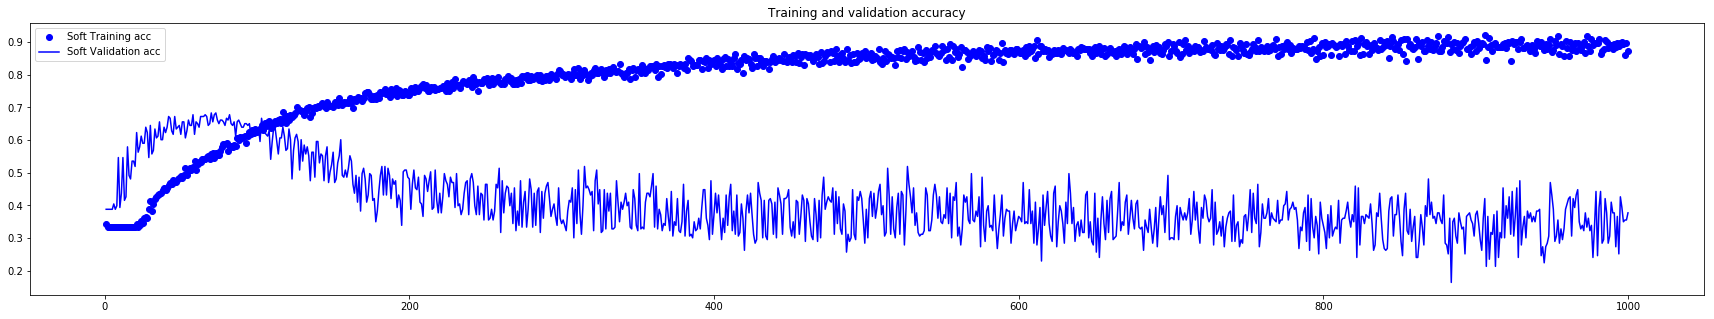

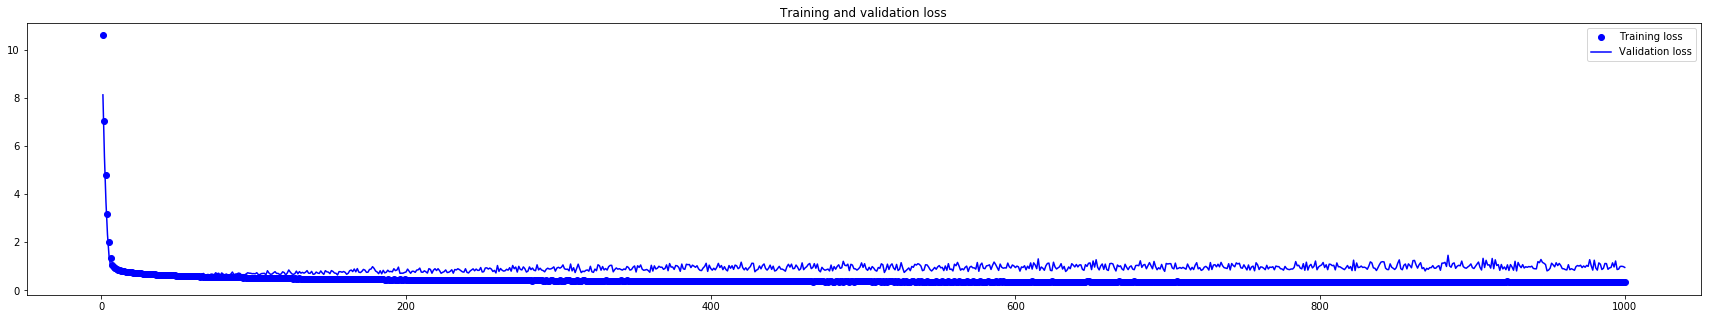

In [25]:
import matplotlib.pyplot as plt

soft_acc = history.history['soft_acc']
soft_val_acc = history.history['val_soft_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(soft_acc) + 1)
plt.figure(figsize=(30,5))
plt.plot(epochs, soft_acc, 'bo', label='Soft Training acc')
plt.plot(epochs, soft_val_acc, 'b', label='Soft Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure(figsize=(30,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


